# TW Hya Imaging Tutorial

This notebook is a tutorial of synthesis imaging based on the sparse modeling technique using PRIISM. 
**PRIISM** is an imaging tool for radio interferometry based on the sparse modeling technique ([PRIISM](https://github.com/tnakazato/priism): Python Module for Radio Interferometry Imaging with Sparse Modeling). 

In this tutorial, we try synthesis imaging for ALMA interferometry data using interactive PRIISM API for ALMA, `priism.alma`. For batch processing using `priism.runner`, please see `tutorial_hltau.ipynb`.

## Setup and Initialize PRIISM

Before you start this tutorial, you should install PRIISM and packages that PRIISM depends on (casatools, casatasks, etc.). Please see README.md on how to install PRIISM. In addition, you need to install `astropy` because this tutorial uses `astropy` to display final image.

There are two fundamental submodules for imaging, `priism.core` and `priism.alma`, which are mainly for interactive use. For batch mode, we have `priism.runner` submodule. This tutorial is using interactive API provided by `priism.alma`. First of all, we create worker instance for interactive imaging.

In [1]:
import priism.alma
print(f'PRIISM version {priism.__version__}')

worker = priism.alma.AlmaSparseModelingImager(solver='mfista_nufft')

LOG: initialize sakura...
<module 'priism.external.sakura.libsakurapy' from '/Users/nakazato/pyenv/priism/lib/python3.8/site-packages/priism/external/sakura/libsakurapy.so'>
PRIISM version 0.11.5


We make matplotlib figures to be displayed in the notebook.

In [2]:
%matplotlib inline

## ALMA Data : TW Hya

Sample data for the tutorial is the protoplanetary disk "**TW Hydra**" observed at Band 7 with ALMA 12m array (Project 2011.0.00340.S). 
The data infromation is taken in [First Look at Imaging CASA 6](https://casaguides.nrao.edu/index.php?title=First_Look_at_Imaging_CASA_6), and the data, which is a calibrated measurement set (MS) for CASA, can be downloaded from the link below: 

https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar

After you download the data, you should extract the MS from the file. You may run the following cell to obtain the dataset.

In [3]:
%%bash
# download if necessary
[ -e sis14_twhya_calibrated_flagged.ms.tar ] || wget -nv https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar

# extract MS if it doesn't exist
[ -e sis14_twhya_calibrated_flagged.ms ] || tar xvf sis14_twhya_calibrated_flagged.ms.tar

## Data Preparation

Next, we average visibility channels according to the procedure described in [the CASA Guide](https://casaguides.nrao.edu/index.php?title=First_Look_at_Imaging_CASA_6#Image_the_science_target). This requires `casatasks` that should have been installed as a dependency of PRIISM. We use `twhya_smoothed.ms` in the subsequent steps.

In [4]:
import os
import shutil
from casatasks import listobs, split, rmtables

outputvis = 'twhya_smoothed.ms'
listfile = 'twhya_smoothed.listobs.txt'

# overwrite output data if it exists
rmtables(outputvis)

split(vis='sis14_twhya_calibrated_flagged.ms', field='5', width='8', outputvis=outputvis, datacolumn='data')

data_summary = listobs(outputvis, verbose=True, overwrite=True, listfile=listfile)

os.system(f'grep -E "^Spectral Windows:" -A 2 {listfile}')

Spectral Windows:  (1 unique spectral windows and 1 unique polarization setups)
  SpwID  Name                           #Chans   Frame   Ch0(MHz)  ChanWid(kHz)  TotBW(kHz) CtrFreq(MHz) BBC Num  Corrs  
  0      ALMA_RB_07#BB_2#SW-01#FULL_RES     48   TOPO  372535.223      4882.812    234375.0 372649.9688        2  XX  YY


0

## Data Selection

Next step is to select visibility data to be processed. The `worker` has `selectdata` method for this purpose. Its interface might be familiar with CASA users. You should set MS to `vis`. Also, you should specify name of data column to use with `datacolumn`. `selectdata` accepts major data selection parameters in CASA. Here, we select data with `spw` and `intent`. 

In [5]:
worker.selectdata(vis='twhya_smoothed.ms',
                  spw='0:24',
                  intent='OBSERVE_TARGET#ON_SOURCE',
                  datacolumn='data')

## Image Configuration

Then, image to be created should be configured with `defineimage` function. Again, parameters for it might be familiar with CASA users. Note that `phasecenter` currently accepts field id only. Also, `nchan` should be 1. These limitation may be relaxed in the future. 

In [6]:
worker.defineimage(imsize=[256, 256],
                   cell=['0.08arcsec'],
                   phasecenter='0',  # TW Hya
                   nchan=1,
                   start=0,
                   width=1)

## Read Visibility Data

Configuration has been done. And actual processing starts from here. First processing step is to read MS and load visibility data onto the memory. 

This step may take up to a minute.

In [7]:
%%timeit -n 1 -r 1

worker.readvis()

***WARN*** refocusing is disabled even if distance to the source is known.


read 200 visibility chunks

DONE reading visibility chunks
8.17 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)



read 270 visibility chunks


## Direct Imaging

Now you can create an image from the visibility data. There are two parameters for imaging: `L1` and `Ltsv`. They are hyper parameters for regularization terms. Once you give these parameters, you will obtain one image. For imaging, you should run `solve` to solve the problem and then run `exportimage` to export the solution as FITS image. 

This step may take up to a minute.

In [8]:
%%timeit -n 1 -r 1
%%capture --no-display capture_solve

worker.solve(l1=1e0, ltsv=1e8, maxiter=1000, storeinitialimage=False, scalehyperparam=False)
worker.exportimage(imagename='twhya_b7cont.fits', overwrite=True)

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 1.09517e+08
lambda_l1:        1
  L1 cost         0
lambda_tsv:       1e+08
  TSV cost        0
total cost        5.47586e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.14029e-05

    1 cost = 54758622.12959, c = 50000000000.00000
   11 cost = 52462580.84038, c = 19277164471.47657
   21 cost = 51649461.65577, c = 7432181401.20717
   31 cost = 51453715.35663, c = 2865427665.05840
   41 cost = 51389090.54457, c = 3151970431.56424
   51 cost = 51370649.55390, c = 3151970431.56424
   61 cost = 51360754.32428, c = 3467167474.72066
   71 cost = 51355467.72160, c = 3151970431.56424
   81 cost = 51352577.74984, c = 3467167474.72066
   91 cost = 51350636.50762, c = 3467167474.72066
  101 cost = 51349338.36022, c = 31519

## Cross-Validation: Finding The Most Reliable Image 

In the previous step, `L1` and `Ltsv` are treated as fixed parameters. In practice, however, these parameters must be optimized to obtain the most reliable image for given visibility data. PRIISM implements a cross validation for optimization. In general, cross validation is time-consuming process because it requires to solve the problem many times and we need to search broad range of `L1-Ltsv` parameter space. This step is a shorthand for  cross validation. We will search only 3x3 parameter space (`L1_list` and `Ltsv_list`) and will perform 4-fold cross validation (default is 10-fold). The most reliable image will be stored in `mycvresult.fits` (i.e., `f'{imageprefix}.fits'`). 

Although this is shorthand, it may take up to tens of minutes depending on the machine spec.

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 1.0952e+08
lambda_l1:        10000
  L1 cost         0
lambda_tsv:       1e+06
  TSV cost        0
total cost        5.4759e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1403e-05

    1 cost = 54758622.12959, c = 50000000000.00000
   11 cost = 52514043.63705, c = 19277164471.47657
   21 cost = 51710447.29426, c = 7432181401.20717
   31 cost = 51494630.86360, c = 2865427665.05840
   41 cost = 51419678.68690, c = 2604934240.96218
   51 cost = 51399334.18167, c = 2152838215.67122
   61 cost = 51388770.90261, c = 2152838215.67122
   71 cost = 51382850.96264, c = 1957125650.61020
   81 cost = 51380116.67556, c = 1779205136.91837
   91 cost = 51378886.54107, c = 1779205136.91837
  101 cost = 51378380.01415, c = 1470

  391 cost = 38356574.47043, c = 1104746407.60900
  401 cost = 38356574.13860, c = 1004314916.00818
  411 cost = 38356573.85207, c = 1004314916.00818
  421 cost = 38356573.63658, c = 1104746407.60900
  431 cost = 38356573.48710, c = 1004314916.00818
  441 cost = 38356573.38374, c = 1104746407.60900
  451 cost = 38356573.29067, c = 1104746407.60900
  461 cost = 38356573.16030, c = 1004314916.00818
  471 cost = 38356573.00137, c = 1004314916.00818
  481 cost = 38356572.85717, c = 1104746407.60900
  491 cost = 38356572.76273, c = 1004314916.00818
  501 cost = 38356572.71395, c = 913013560.00744
  511 cost = 38356572.67441, c = 1104746407.60900
  521 cost = 38356572.62342, c = 1004314916.00818
  531 cost = 38356572.55426, c = 1104746407.60900
  541 cost = 38356572.47333, c = 1004314916.00818
  551 cost = 38356572.40353, c = 1104746407.60900
  561 cost = 38356572.36286, c = 1104746407.60900
  571 cost = 38356572.34276, c = 1004314916.00818
  581 cost = 38356572.32426, c = 913013560.00744
  

  881 cost = 38336705.82479, c = 1004314916.00818
  891 cost = 38336705.82220, c = 1004314916.00818
  901 cost = 38336705.82105, c = 913013560.00743
  911 cost = 38336705.82045, c = 913013560.00743
  921 cost = 38336705.81914, c = 913013560.00743
  931 cost = 38336705.81664, c = 1004314916.00818
  941 cost = 38336705.81388, c = 1004314916.00818
  951 cost = 38336705.81192, c = 1004314916.00818
  961 cost = 38336705.81091, c = 913013560.00743
  971 cost = 38336705.81016, c = 913013560.00743
  981 cost = 38336705.80910, c = 913013560.00743
  991 cost = 38336705.80771, c = 913013560.00743
 1000 cost = 38336705.80647

Cleaning fftw plan.

 computation time: 27.315
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 7.6202e+07
lambda_l1:        10000
  L1 cost         21.58
lambda_tsv:       1e+06
  TSV cost        0.02011
total cost        3.8337e+07

compute Fourier Transform
Memory allocation and preparations.

Pr

  211 cost = 38441092.65927, c = 913013560.00743
  221 cost = 38441087.27024, c = 1004314916.00818
  231 cost = 38441082.67265, c = 913013560.00743
  241 cost = 38441078.69617, c = 1004314916.00818
  251 cost = 38441075.58048, c = 1004314916.00818
  261 cost = 38441073.31130, c = 913013560.00743
  271 cost = 38441071.63641, c = 1104746407.60900
  281 cost = 38441070.36713, c = 913013560.00743
  291 cost = 38441069.27358, c = 1004314916.00818
  301 cost = 38441068.22340, c = 1104746407.60900
  311 cost = 38441067.12230, c = 1104746407.60900
  321 cost = 38441066.14618, c = 913013560.00743
  331 cost = 38441065.45932, c = 1004314916.00818
  341 cost = 38441064.97199, c = 913013560.00743
  351 cost = 38441064.49168, c = 1104746407.60900
  361 cost = 38441064.01146, c = 1004314916.00818
  371 cost = 38441063.64336, c = 1004314916.00818
  381 cost = 38441063.35355, c = 913013560.00743
  391 cost = 38441063.06009, c = 1004314916.00818
  401 cost = 38441062.79766, c = 1004314916.00818
  411 c

  701 cost = 51063887.08853, c = 2865427665.05840
  711 cost = 51063884.62617, c = 2604934240.96218
  721 cost = 51063882.50586, c = 2604934240.96218
  731 cost = 51063880.79708, c = 2368122037.23835
  741 cost = 51063879.51348, c = 2865427665.05840
  751 cost = 51063878.66365, c = 2604934240.96218
  761 cost = 51063878.21015, c = 2604934240.96218
  771 cost = 51063878.08170, c = 2604934240.96218
  781 cost = 51063877.96304, c = 2604934240.96218
  791 cost = 51063877.84244, c = 2604934240.96218
  801 cost = 51063877.75792, c = 2604934240.96218
  811 cost = 51063877.68161, c = 1957125650.61020
  821 cost = 51063877.62525, c = 1957125650.61020
  831 cost = 51063877.57274, c = 2865427665.05840
  841 cost = 51063877.53167, c = 2152838215.67122
  851 cost = 51063877.47962, c = 2865427665.05840
  861 cost = 51063877.40655, c = 2368122037.23835
  871 cost = 51063877.37022, c = 2152838215.67122
  881 cost = 51063877.18243, c = 2865427665.05840
  891 cost = 51063876.94783, c = 2604934240.96218


   31 cost = 38280124.55029, c = 2865427665.05840
   41 cost = 38150854.54645, c = 1470417468.52757
   51 cost = 38104409.80179, c = 2368122037.23835
   61 cost = 38080447.15938, c = 2368122037.23835
   71 cost = 38064977.70635, c = 2152838215.67122
   81 cost = 38054582.30641, c = 2152838215.67122
   91 cost = 38047428.39407, c = 2152838215.67122
  101 cost = 38042476.26160, c = 2152838215.67122
  111 cost = 38039126.49512, c = 1957125650.61020
  121 cost = 38036812.28596, c = 1957125650.61020
  131 cost = 38035227.19930, c = 1957125650.61020
  141 cost = 38034132.57273, c = 2152838215.67122
  151 cost = 38033363.86523, c = 2152838215.67122
  161 cost = 38032827.53155, c = 1779205136.91837
  171 cost = 38032448.83568, c = 1779205136.91837
  181 cost = 38032179.19433, c = 1957125650.61020
  191 cost = 38031989.79751, c = 1957125650.61020
  201 cost = 38031858.05720, c = 1779205136.91837
  211 cost = 38031763.43493, c = 2152838215.67122
  221 cost = 38031695.66436, c = 1957125650.61020


  511 cost = 38174112.28066, c = 1957125650.61020
  521 cost = 38174111.66830, c = 2152838215.67122
  531 cost = 38174110.71732, c = 2152838215.67122
  541 cost = 38174109.35226, c = 2152838215.67122
  551 cost = 38174107.57608, c = 1957125650.61020
  561 cost = 38174105.43656, c = 1779205136.91837
  571 cost = 38174103.03140, c = 1957125650.61020
  581 cost = 38174100.50239, c = 1957125650.61020
  591 cost = 38174098.00027, c = 1957125650.61020
  601 cost = 38174095.68042, c = 1779205136.91837
  611 cost = 38174093.65217, c = 1957125650.61020
  621 cost = 38174091.99342, c = 2152838215.67122
  631 cost = 38174090.74642, c = 1957125650.61020
  641 cost = 38174089.89918, c = 1957125650.61020
  651 cost = 38174089.41530, c = 1957125650.61020
  661 cost = 38174089.20032, c = 1957125650.61020
  671 cost = 38174089.13610, c = 1779205136.91837
  681 cost = 38174089.10787, c = 1957125650.61020
  691 cost = 38174089.02515, c = 1957125650.61020
  701 cost = 38174088.84547, c = 1779205136.91837


  991 cost = 38119186.47903, c = 1957125650.61020
 1000 cost = 38119186.26965

Cleaning fftw plan.

 computation time: 41.184
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 7.602e+07
lambda_l1:        1000
  L1 cost         76.813
lambda_tsv:       1e+06
  TSV cost        0.032372
total cost        3.8119e+07

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 1.0952e+08
lambda_l1:        100
  L1 cost         0
lambda_tsv:       1e+06
  TSV cost        0
total cost        5.4759e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1403e-05

    1 cost = 54758622.12959, c = 50000000000.00000
   11 cost = 52454334.47115, c = 19277164471.47657
   21 cost = 51577422.65281, c = 7432181401.207

  311 cost = 37945770.88023, c = 2604934240.96218
  321 cost = 37945285.07192, c = 2604934240.96218
  331 cost = 37944853.66664, c = 2368122037.23835
  341 cost = 37944472.56196, c = 2368122037.23835
  351 cost = 37944137.11076, c = 2368122037.23835
  361 cost = 37943842.79064, c = 2368122037.23835
  371 cost = 37943585.10129, c = 2604934240.96218
  381 cost = 37943360.23862, c = 2604934240.96218
  391 cost = 37943164.76403, c = 2368122037.23835
  401 cost = 37942995.38164, c = 2368122037.23835
  411 cost = 37942848.87172, c = 2368122037.23835
  421 cost = 37942722.40782, c = 2604934240.96218
  431 cost = 37942613.67575, c = 2604934240.96218
  441 cost = 37942521.04299, c = 2368122037.23835
  451 cost = 37942443.09662, c = 2368122037.23835
  461 cost = 37942378.33665, c = 1779205136.91837
  471 cost = 37942324.79563, c = 2368122037.23835
  481 cost = 37942281.78247, c = 2604934240.96218
  491 cost = 37942248.31610, c = 2368122037.23835
  501 cost = 37942222.87148, c = 2604934240.96218


  791 cost = 37935402.23043, c = 2604934240.96218
  801 cost = 37935396.26931, c = 2152838215.67122
  811 cost = 37935389.92004, c = 2604934240.96218
  821 cost = 37935383.36202, c = 2368122037.23835
  831 cost = 37935376.75100, c = 2368122037.23835
  841 cost = 37935370.21984, c = 2368122037.23835
  851 cost = 37935363.87826, c = 2368122037.23835
  861 cost = 37935357.81662, c = 2152838215.67122
  871 cost = 37935352.09934, c = 2368122037.23835
  881 cost = 37935346.76862, c = 2368122037.23835
  891 cost = 37935341.87845, c = 2152838215.67122
  901 cost = 37935337.44798, c = 2152838215.67122
  911 cost = 37935333.48851, c = 2152838215.67122
  921 cost = 37935330.00271, c = 2152838215.67122
  931 cost = 37935326.98435, c = 2368122037.23835
  941 cost = 37935324.40475, c = 2368122037.23835
  951 cost = 37935322.22585, c = 2152838215.67122
  961 cost = 37935320.40978, c = 2152838215.67122
  971 cost = 37935318.91647, c = 2604934240.96218
  981 cost = 37935317.72225, c = 1957125650.61020


  111 cost = 38060844.75506, c = 2152838215.67122
  121 cost = 38055291.82959, c = 2152838215.67122
  131 cost = 38050761.54710, c = 2152838215.67122
  141 cost = 38047013.06979, c = 1957125650.61020
  151 cost = 38043868.92705, c = 2152838215.67122
  161 cost = 38041164.62817, c = 2152838215.67122
  171 cost = 38038806.33658, c = 2152838215.67122
  181 cost = 38036751.23129, c = 2152838215.67122
  191 cost = 38034950.69477, c = 2152838215.67122
  201 cost = 38033361.96777, c = 2368122037.23835
  211 cost = 38031965.02670, c = 2152838215.67122
  221 cost = 38030735.04770, c = 2368122037.23835
  231 cost = 38029652.46869, c = 2152838215.67122
  241 cost = 38028700.76620, c = 2368122037.23835
  251 cost = 38027864.35534, c = 2152838215.67122
  261 cost = 38027126.66668, c = 2368122037.23835
  271 cost = 38026475.50647, c = 2368122037.23835
  281 cost = 38025901.49369, c = 2368122037.23835
  291 cost = 38025396.56915, c = 2152838215.67122
  301 cost = 38024953.74529, c = 2368122037.23835


  591 cost = 51450793.54095, c = 1957125650.61020
  601 cost = 51450793.53892, c = 1957125650.61020
  611 cost = 51450793.53228, c = 1957125650.61020
  621 cost = 51450793.52351, c = 1957125650.61020
  631 cost = 51450793.51828, c = 1957125650.61020
  641 cost = 51450793.51580, c = 1779205136.91837
  651 cost = 51450793.51394, c = 2152838215.67122
  661 cost = 51450793.50814, c = 1957125650.61020
  671 cost = 51450793.50542, c = 1779205136.91837
  681 cost = 51450793.50393, c = 1779205136.91837
  691 cost = 51450793.50227, c = 1957125650.61020
  701 cost = 51450793.50100, c = 2152838215.67122
  711 cost = 51450793.49739, c = 2604934240.96218
  721 cost = 51450793.49529, c = 1779205136.91837
  731 cost = 51450793.49451, c = 1779205136.91837
  741 cost = 51450793.49397, c = 1617459215.38033
  751 cost = 51450793.49327, c = 1779205136.91837
  761 cost = 51450793.49265, c = 1779205136.91837
  771 cost = 51450793.49171, c = 2152838215.67122
  781 cost = 51450793.49094, c = 1470417468.52757


   11 cost = 39447458.65939, c = 19277164471.47657
   21 cost = 38686541.24765, c = 7432181401.20717
   31 cost = 38479652.60820, c = 2865427665.05840
   41 cost = 38423192.19574, c = 1104746407.60900
   51 cost = 38416150.61882, c = 1617459215.38033
   61 cost = 38414368.78120, c = 1617459215.38033
   71 cost = 38413253.82420, c = 1470417468.52757
   81 cost = 38412761.19649, c = 1617459215.38033
   91 cost = 38412466.66408, c = 1470417468.52757
  101 cost = 38412318.06693, c = 1470417468.52757
  111 cost = 38412236.31820, c = 1470417468.52757
  121 cost = 38412189.66329, c = 1617459215.38033
  131 cost = 38412152.44736, c = 1470417468.52757
  141 cost = 38412126.26950, c = 1470417468.52757
  151 cost = 38412111.15980, c = 1470417468.52757
  161 cost = 38412101.00996, c = 1470417468.52757
  171 cost = 38412093.27110, c = 1470417468.52757
  181 cost = 38412088.38353, c = 1336743153.20689
  191 cost = 38412084.33049, c = 1617459215.38033
  201 cost = 38412080.05746, c = 1336743153.20689

  491 cost = 38548085.28654, c = 1470417468.52757
  501 cost = 38548085.27942, c = 1617459215.38033
  511 cost = 38548085.27227, c = 1470417468.52757
  521 cost = 38548085.26658, c = 913013560.00744
  531 cost = 38548085.25643, c = 1470417468.52757
  541 cost = 38548085.25394, c = 1336743153.20689
  551 cost = 38548085.25103, c = 1215221048.36990
  561 cost = 38548085.24827, c = 1104746407.60900
  571 cost = 38548085.24462, c = 1470417468.52757
  581 cost = 38548085.24167, c = 1470417468.52757
  591 cost = 38548085.23998, c = 1336743153.20689
  601 cost = 38548085.23875, c = 1104746407.60900
  611 cost = 38548085.23537, c = 1779205136.91837
  621 cost = 38548085.23425, c = 1617459215.38033
  631 cost = 38548085.23316, c = 1617459215.38033
  641 cost = 38548085.23165, c = 1779205136.91837
  651 cost = 38548085.23111, c = 1104746407.60900
  661 cost = 38548085.23051, c = 1336743153.20689
  671 cost = 38548085.23023, c = 1470417468.52757
  681 cost = 38548085.22944, c = 1470417468.52757
 

  971 cost = 38519611.84126, c = 1470417468.52757
  981 cost = 38519611.84124, c = 1617459215.38033
  991 cost = 38519611.84116, c = 1617459215.38033
 1000 cost = 38519611.84112

Cleaning fftw plan.

 computation time: 39.639
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 7.6506e+07
lambda_l1:        10000
  L1 cost         21.517
lambda_tsv:       1e+07
  TSV cost        0.0051613
total cost        3.852e+07

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 1.0952e+08
lambda_l1:        1000
  L1 cost         0
lambda_tsv:       1e+07
  TSV cost        0
total cost        5.4759e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1403e-05

    1 cost = 54758622.12959, c = 50000000000.0

  291 cost = 38151911.92538, c = 2604934240.96218
  301 cost = 38151901.55385, c = 2368122037.23835
  311 cost = 38151894.03983, c = 2368122037.23835
  321 cost = 38151888.93382, c = 2604934240.96218
  331 cost = 38151885.09769, c = 2604934240.96218
  341 cost = 38151881.91825, c = 2368122037.23835
  351 cost = 38151879.44982, c = 2152838215.67122
  361 cost = 38151877.77488, c = 2368122037.23835
  371 cost = 38151876.58431, c = 2152838215.67122
  381 cost = 38151875.32287, c = 2368122037.23835
  391 cost = 38151873.77607, c = 2152838215.67122
  401 cost = 38151872.04870, c = 2368122037.23835
  411 cost = 38151870.32557, c = 2152838215.67122
  421 cost = 38151868.52271, c = 2368122037.23835
  431 cost = 38151866.49807, c = 2152838215.67122
  441 cost = 38151864.26674, c = 2368122037.23835
  451 cost = 38151862.04751, c = 2604934240.96218
  461 cost = 38151860.05525, c = 2368122037.23835
  471 cost = 38151858.42018, c = 2368122037.23835
  481 cost = 38151857.23844, c = 2604934240.96218


  771 cost = 38139227.98021, c = 2152838215.67122
  781 cost = 38139227.90909, c = 2368122037.23835
  791 cost = 38139227.80521, c = 2152838215.67122
  801 cost = 38139227.68178, c = 2368122037.23835
  811 cost = 38139227.55967, c = 2152838215.67122
  821 cost = 38139227.45349, c = 2368122037.23835
  831 cost = 38139227.37073, c = 2152838215.67122
  841 cost = 38139227.31712, c = 2368122037.23835
  851 cost = 38139227.29738, c = 2152838215.67122
  861 cost = 38139227.28206, c = 2368122037.23835
  871 cost = 38139227.27167, c = 1336743153.20689
  881 cost = 38139227.25624, c = 2152838215.67122
  891 cost = 38139227.25091, c = 1957125650.61020
  901 cost = 38139227.24061, c = 1779205136.91837
  911 cost = 38139227.23484, c = 1957125650.61020
  921 cost = 38139227.20863, c = 2152838215.67122
  931 cost = 38139227.16766, c = 2152838215.67122
  941 cost = 38139227.10710, c = 2368122037.23835
  951 cost = 38139227.03448, c = 2368122037.23835
  961 cost = 38139226.96623, c = 2368122037.23835


   91 cost = 38233812.83196, c = 2368122037.23835
  101 cost = 38232447.29699, c = 2368122037.23835
  111 cost = 38231718.23679, c = 2368122037.23835
  121 cost = 38231279.76841, c = 2152838215.67122
  131 cost = 38231006.28038, c = 2368122037.23835
  141 cost = 38230851.38834, c = 2152838215.67122
  151 cost = 38230743.50804, c = 2368122037.23835
  161 cost = 38230678.93388, c = 2368122037.23835
  171 cost = 38230641.49905, c = 2368122037.23835
  181 cost = 38230606.98492, c = 2368122037.23835
  191 cost = 38230570.83814, c = 2152838215.67122
  201 cost = 38230534.41667, c = 2368122037.23835
  211 cost = 38230496.64358, c = 2368122037.23835
  221 cost = 38230455.78173, c = 2368122037.23835
  231 cost = 38230413.40054, c = 2368122037.23835
  241 cost = 38230374.31381, c = 2152838215.67122
  251 cost = 38230342.06096, c = 2368122037.23835
  261 cost = 38230318.99423, c = 2368122037.23835
  271 cost = 38230305.05347, c = 2152838215.67122
  281 cost = 38230298.33116, c = 2368122037.23835


  571 cost = 51099270.16345, c = 3467167474.72066
  581 cost = 51099269.22153, c = 3467167474.72066
  591 cost = 51099267.46260, c = 3467167474.72066
  601 cost = 51099264.89940, c = 3467167474.72066
  611 cost = 51099261.68729, c = 3151970431.56424
  621 cost = 51099257.96728, c = 3151970431.56424
  631 cost = 51099253.86068, c = 3151970431.56424
  641 cost = 51099249.50182, c = 3467167474.72066
  651 cost = 51099245.03988, c = 3467167474.72066
  661 cost = 51099240.61751, c = 3467167474.72066
  671 cost = 51099236.34895, c = 3467167474.72066
  681 cost = 51099232.32802, c = 3467167474.72066
  691 cost = 51099228.63366, c = 3151970431.56424
  701 cost = 51099225.30858, c = 3151970431.56424
  711 cost = 51099222.37838, c = 3151970431.56424
  721 cost = 51099219.85220, c = 3151970431.56424
  731 cost = 51099217.73945, c = 3151970431.56424
  741 cost = 51099216.07383, c = 3467167474.72066
  751 cost = 51099214.87809, c = 3151970431.56424
  761 cost = 51099214.14888, c = 3467167474.72066


   11 cost = 39395260.90913, c = 19277164471.47657
   21 cost = 38562051.34813, c = 7432181401.20717
   31 cost = 38283955.93694, c = 2865427665.05840
   41 cost = 38168905.63975, c = 1470417468.52757
   51 cost = 38132385.41687, c = 2368122037.23835
   61 cost = 38113514.26591, c = 2368122037.23835
   71 cost = 38101468.22613, c = 2604934240.96218
   81 cost = 38093945.37377, c = 2368122037.23835
   91 cost = 38088880.58177, c = 2368122037.23835
  101 cost = 38085376.36298, c = 2152838215.67122
  111 cost = 38082756.11398, c = 2368122037.23835
  121 cost = 38080784.89649, c = 2152838215.67122
  131 cost = 38079238.27766, c = 2604934240.96218
  141 cost = 38077991.80203, c = 2368122037.23835
  151 cost = 38076981.64428, c = 2368122037.23835
  161 cost = 38076163.31476, c = 2368122037.23835
  171 cost = 38075506.06503, c = 2368122037.23835
  181 cost = 38074972.40810, c = 2604934240.96218
  191 cost = 38074536.01026, c = 2368122037.23835
  201 cost = 38074181.79466, c = 2604934240.96218

  491 cost = 38209314.70610, c = 2604934240.96218
  501 cost = 38209313.18278, c = 2368122037.23835
  511 cost = 38209310.82389, c = 2368122037.23835
  521 cost = 38209307.80596, c = 2368122037.23835
  531 cost = 38209304.27918, c = 2604934240.96218
  541 cost = 38209300.33299, c = 2604934240.96218
  551 cost = 38209296.01614, c = 2368122037.23835
  561 cost = 38209291.34954, c = 2604934240.96218
  571 cost = 38209286.41848, c = 2604934240.96218
  581 cost = 38209281.34869, c = 2604934240.96218
  591 cost = 38209276.30219, c = 2368122037.23835
  601 cost = 38209271.42859, c = 2604934240.96218
  611 cost = 38209266.87438, c = 2604934240.96218
  621 cost = 38209262.72098, c = 2604934240.96218
  631 cost = 38209259.00875, c = 2604934240.96218
  641 cost = 38209255.74018, c = 2604934240.96218
  651 cost = 38209252.90735, c = 2604934240.96218
  661 cost = 38209250.50962, c = 2604934240.96218
  671 cost = 38209248.54025, c = 2604934240.96218
  681 cost = 38209246.98893, c = 2604934240.96218


  971 cost = 38160590.46086, c = 2152838215.67122
  981 cost = 38160590.44387, c = 1779205136.91837
  991 cost = 38160590.43792, c = 2368122037.23835
 1000 cost = 38160590.42917

Cleaning fftw plan.

 computation time: 28.108
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 7.6136e+07
lambda_l1:        100
  L1 cost         107.35
lambda_tsv:       1e+07
  TSV cost        0.0082002
total cost        3.8161e+07

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 1.0952e+08
lambda_l1:        10000
  L1 cost         0
lambda_tsv:       1e+08
  TSV cost        0
total cost        5.4759e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1403e-05

    1 cost = 54758622.12959, c = 50000000000.0

  371 cost = 38616316.86403, c = 1336743153.20689
  381 cost = 38616316.85349, c = 1215221048.36990
  391 cost = 38616316.83811, c = 2152838215.67122
  401 cost = 38616316.83559, c = 2368122037.23835
  411 cost = 38616316.82882, c = 2152838215.67122
  421 cost = 38616316.82321, c = 2152838215.67122
  431 cost = 38616316.81684, c = 2368122037.23835
  441 cost = 38616316.81555, c = 1779205136.91837
  451 cost = 38616316.81369, c = 2152838215.67122
  461 cost = 38616316.80573, c = 2152838215.67122
  471 cost = 38616316.80400, c = 1336743153.20689
  481 cost = 38616316.80277, c = 2368122037.23835
  491 cost = 38616316.80021, c = 2368122037.23835
  501 cost = 38616316.79931, c = 1336743153.20689
  511 cost = 38616316.79878, c = 2604934240.96218
  521 cost = 38616316.79813, c = 2152838215.67122
  531 cost = 38616316.79769, c = 2368122037.23835
  541 cost = 38616316.79735, c = 1617459215.38033
  551 cost = 38616316.79682, c = 2368122037.23835
  561 cost = 38616316.79589, c = 1957125650.61020


   51 cost = 38735025.00333, c = 1779205136.91837
   61 cost = 38734297.46166, c = 1957125650.61020
   71 cost = 38733852.70785, c = 2152838215.67122
   81 cost = 38733638.87618, c = 2152838215.67122
   91 cost = 38733570.44427, c = 2152838215.67122
  101 cost = 38733529.76141, c = 1957125650.61020
  111 cost = 38733492.94609, c = 2152838215.67122
  121 cost = 38733473.42331, c = 2152838215.67122
  131 cost = 38733462.24209, c = 2152838215.67122
  141 cost = 38733456.52861, c = 2152838215.67122
  151 cost = 38733452.86336, c = 2152838215.67122
  161 cost = 38733446.09620, c = 1957125650.61020
  171 cost = 38733444.21088, c = 1779205136.91837
  181 cost = 38733443.27326, c = 1617459215.38033
  191 cost = 38733442.05729, c = 1957125650.61020
  201 cost = 38733441.26288, c = 2152838215.67122
  211 cost = 38733440.66955, c = 2152838215.67122
  221 cost = 38733440.34709, c = 2152838215.67122
  231 cost = 38733439.89470, c = 2152838215.67122
  241 cost = 38733439.46974, c = 2368122037.23835


  721 cost = 38704206.91246, c = 2368122037.23835
  731 cost = 38704206.91243, c = 2152838215.67122
  741 cost = 38704206.91241, c = 1470417468.52757
  751 cost = 38704206.91239, c = 1779205136.91837
  761 cost = 38704206.91237, c = 1779205136.91837
  771 cost = 38704206.91235, c = 1779205136.91837
  781 cost = 38704206.91234, c = 1779205136.91837
  791 cost = 38704206.91233, c = 1617459215.38033
  792 cost = 38704206.91233

Cleaning fftw plan.

 computation time: 26.441
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 7.6811e+07
lambda_l1:        10000
  L1 cost         18.42
lambda_tsv:       1e+08
  TSV cost        0.001146
total cost        3.8704e+07

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 1.0952e+08
lambda_l1:        1000
  L1 cost         0
lambda_tsv:       1e+08
  TSV cost        0
total cost        5.4759e+07

Me

  241 cost = 38388541.75157, c = 2865427665.05840
  251 cost = 38388535.95504, c = 2368122037.23835
  261 cost = 38388525.78521, c = 2865427665.05840
  271 cost = 38388518.08966, c = 2865427665.05840
  281 cost = 38388515.94777, c = 2604934240.96218
  291 cost = 38388515.29217, c = 2152838215.67122
  301 cost = 38388514.21588, c = 2604934240.96218
  311 cost = 38388512.16053, c = 2368122037.23835
  321 cost = 38388508.41088, c = 2865427665.05840
  331 cost = 38388504.77775, c = 2865427665.05840
  341 cost = 38388503.02248, c = 2865427665.05840
  351 cost = 38388502.85552, c = 2604934240.96218
  361 cost = 38388502.62939, c = 2368122037.23835
  371 cost = 38388502.48426, c = 2152838215.67122
  381 cost = 38388502.26340, c = 2152838215.67122
  391 cost = 38388501.97859, c = 2604934240.96218
  401 cost = 38388501.35661, c = 2604934240.96218
  411 cost = 38388500.28396, c = 2604934240.96218
  421 cost = 38388499.26067, c = 2865427665.05840
  431 cost = 38388498.63582, c = 2865427665.05840


  721 cost = 38369667.12705, c = 2604934240.96218
  731 cost = 38369667.07783, c = 2368122037.23835
  741 cost = 38369667.01916, c = 2368122037.23835
  751 cost = 38369666.96884, c = 2368122037.23835
  761 cost = 38369666.94301, c = 2604934240.96218
  771 cost = 38369666.93585, c = 1617459215.38033
  781 cost = 38369666.92697, c = 2604934240.96218
  791 cost = 38369666.92086, c = 2865427665.05840
  801 cost = 38369666.91548, c = 2604934240.96218
  811 cost = 38369666.90432, c = 2368122037.23835
  821 cost = 38369666.89932, c = 2604934240.96218
  831 cost = 38369666.89020, c = 2368122037.23835
  841 cost = 38369666.86589, c = 2604934240.96218
  851 cost = 38369666.83351, c = 2604934240.96218
  861 cost = 38369666.81189, c = 2604934240.96218
  871 cost = 38369666.80881, c = 1617459215.38033
  881 cost = 38369666.80559, c = 1617459215.38033
  891 cost = 38369666.80391, c = 2152838215.67122
  901 cost = 38369666.80102, c = 2368122037.23835
  911 cost = 38369666.79241, c = 2604934240.96218


   41 cost = 38493343.84852, c = 1957125650.61020
   51 cost = 38480338.87794, c = 2604934240.96218
   61 cost = 38475877.50116, c = 2604934240.96218
   71 cost = 38474255.87201, c = 2604934240.96218
   81 cost = 38473670.14552, c = 2604934240.96218
   91 cost = 38473238.50636, c = 2368122037.23835
  101 cost = 38472962.42447, c = 2368122037.23835
  111 cost = 38472747.20749, c = 2865427665.05840
  121 cost = 38472615.80911, c = 2604934240.96218
  131 cost = 38472518.14668, c = 2604934240.96218
  141 cost = 38472377.48600, c = 2368122037.23835
  151 cost = 38472252.90998, c = 2604934240.96218
  161 cost = 38472179.69421, c = 2604934240.96218
  171 cost = 38472142.14875, c = 2604934240.96218
  181 cost = 38472130.72985, c = 2604934240.96218
  191 cost = 38472124.74695, c = 2865427665.05840
  201 cost = 38472120.91544, c = 2604934240.96218
  211 cost = 38472115.34724, c = 2604934240.96218
  221 cost = 38472102.35335, c = 2604934240.96218
  231 cost = 38472087.46297, c = 2604934240.96218


  521 cost = 51352463.91581, c = 3467167474.72066
  531 cost = 51352462.57462, c = 3467167474.72066
  541 cost = 51352461.59264, c = 3467167474.72066
  551 cost = 51352461.06855, c = 3467167474.72066
  561 cost = 51352460.96759, c = 2865427665.05840
  571 cost = 51352460.93327, c = 2368122037.23834
  581 cost = 51352460.90649, c = 2604934240.96218
  591 cost = 51352460.88850, c = 3813884222.19273
  601 cost = 51352460.86841, c = 3813884222.19273
  611 cost = 51352460.85166, c = 3151970431.56424
  621 cost = 51352460.83476, c = 3151970431.56424
  631 cost = 51352460.81283, c = 2865427665.05840
  641 cost = 51352460.78814, c = 2865427665.05840
  651 cost = 51352460.76699, c = 2865427665.05840
  661 cost = 51352460.73293, c = 3813884222.19273
  671 cost = 51352460.69675, c = 3467167474.72066
  681 cost = 51352460.63818, c = 3467167474.72066
  691 cost = 51352460.50916, c = 3467167474.72066
  701 cost = 51352460.30033, c = 3467167474.72066
  711 cost = 51352460.04020, c = 3813884222.19273


 1000 cost = 38343258.19282

Cleaning fftw plan.

 computation time: 29.239
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 7.6366e+07
lambda_l1:        100
  L1 cost         61.783
lambda_tsv:       1e+08
  TSV cost        0.0015402
total cost        3.8343e+07

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 8.2e+07
lambda_l1:        100
  L1 cost         0
lambda_tsv:       1e+08
  TSV cost        0
total cost        4.1e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1211e-05

    1 cost = 40999766.33892, c = 50000000000.00000
   11 cost = 39401210.33906, c = 19277164471.47657
   21 cost = 38620822.50621, c = 7432181401.20717
   31 cost = 38425731.27723, c = 2865427665.05840
  

  321 cost = 38464227.57663, c = 2604934240.96218
  331 cost = 38464223.60803, c = 2604934240.96218
  341 cost = 38464220.89736, c = 2865427665.05840
  351 cost = 38464218.71014, c = 2604934240.96218
  361 cost = 38464217.18390, c = 2604934240.96218
  371 cost = 38464216.87234, c = 1957125650.61020
  381 cost = 38464216.77737, c = 1617459215.38033
  391 cost = 38464216.69435, c = 2368122037.23835
  401 cost = 38464216.62674, c = 1470417468.52757
  411 cost = 38464216.56291, c = 1779205136.91837
  421 cost = 38464216.51524, c = 2368122037.23835
  431 cost = 38464216.46148, c = 3151970431.56424
  441 cost = 38464216.37749, c = 2604934240.96218
  451 cost = 38464216.31235, c = 2152838215.67122
  461 cost = 38464216.24039, c = 2368122037.23835
  471 cost = 38464216.05169, c = 2604934240.96218
  481 cost = 38464215.81442, c = 2865427665.05840
  491 cost = 38464215.36110, c = 2604934240.96218
  501 cost = 38464214.63054, c = 2604934240.96218
  511 cost = 38464213.71914, c = 2865427665.05840


  801 cost = 38428055.11652, c = 2604934240.96218
  811 cost = 38428055.11145, c = 1779205136.91837
  821 cost = 38428055.10406, c = 2152838215.67122
  831 cost = 38428055.09928, c = 2604934240.96218
  841 cost = 38428055.09507, c = 2865427665.05840
  851 cost = 38428055.09068, c = 2604934240.96218
  861 cost = 38428055.08621, c = 2604934240.96218
  871 cost = 38428055.08329, c = 2368122037.23835
  881 cost = 38428055.07865, c = 2368122037.23835
  891 cost = 38428055.07398, c = 2152838215.67122
  901 cost = 38428055.05937, c = 2604934240.96218
  911 cost = 38428055.05283, c = 2604934240.96218
  921 cost = 38428055.03323, c = 2865427665.05840
  931 cost = 38428054.98314, c = 2865427665.05840
  941 cost = 38428054.91282, c = 2604934240.96218
  951 cost = 38428054.85290, c = 2604934240.96218
  961 cost = 38428054.83328, c = 2604934240.96218
  971 cost = 38428054.83090, c = 2604934240.96218
  981 cost = 38428054.82932, c = 1779205136.91837
  991 cost = 38428054.82810, c = 1779205136.91837


{'L1': 10000.0, 'Ltsv': 100000000.0}

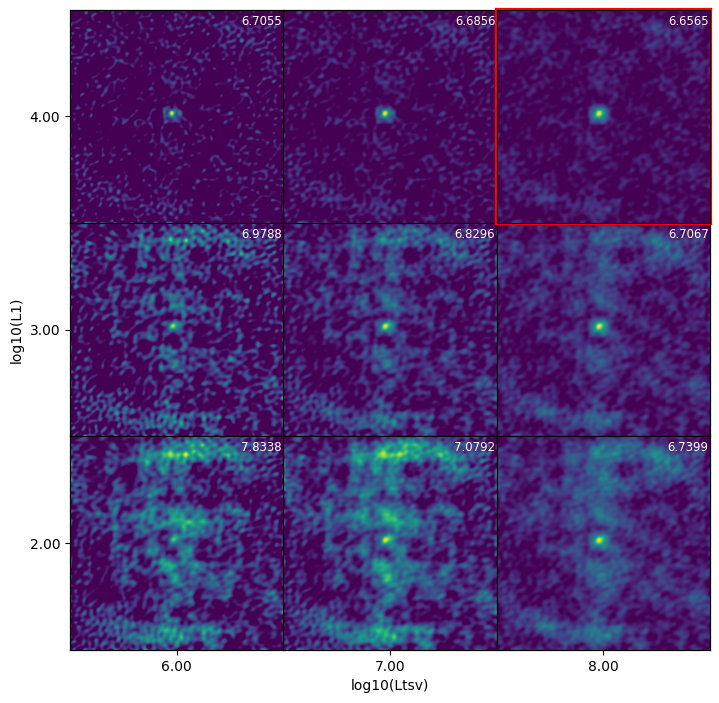

23min 55s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
%%timeit -n 1 -r 1
%%capture --no-display capture_cv

L1_list = [1e2, 1e3, 1e4]
Ltsv_list = [1e6, 1e7, 1e8]
num_fold = 4

worker.crossvalidation(L1_list, Ltsv_list, num_fold=num_fold,
                       imageprefix='twhya_b7cont_cv', imagepolicy='full',
                       summarize=True, figfile='cvresult.png',
                       datafile='cvresult.dat', maxiter=1000, resultasinitialimage=False, scalehyperparam=False)

## Accelerating cross-validation with Bayesian optimization

The `crossvalidation` method has an option to choose optimizer. Default optimizer is `'classical'` which evaluates each pair of `L1` and `Ltsv` in order to find the most reliable combination. In general, `'classical'` optimizer takes time because all combinations of given sets of `L1` and `Ltsv` must be evaluated. This makes practically difficult to seach wide range of `L1` and `Ltsv`. To address this issue, we've introduced another optimizer, `'bayesian'`. The `'bayesian'` optimizer performs Bayesian optimization to reach the most reliable combination with less number of evaluation instead of evaluating individual hyperparameter pairs. Below is an example of obtaining the best result among 12x12 hyperparameters (144 pairs) with up to 15 evaluations, i.e. almost 1/10 of total number of combinations. You will see the same (or close) result to the one obtained by the `'classical'` optimizer. You can choose, or combine, these optimizers as needed to reach the best image. 

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 1.0952e+08
lambda_l1:        0.1
  L1 cost         0
lambda_tsv:       10000
  TSV cost        0
total cost        5.4759e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1403e-05

    1 cost = 54758622.12959, c = 50000000000.00000
   11 cost = 52453626.67509, c = 19277164471.47657
   21 cost = 51575124.26809, c = 7432181401.20717
   31 cost = 51286100.61785, c = 2865427665.05840
   41 cost = 51153161.32385, c = 3151970431.56424
   51 cost = 51100999.91958, c = 3151970431.56424
   61 cost = 51066720.12430, c = 3151970431.56424
   71 cost = 51041616.97596, c = 3151970431.56424
   81 cost = 51021988.88366, c = 3151970431.56424
   91 cost = 51005683.34581, c = 3467167474.72066
  101 cost = 50991827.04047, c = 315197

  391 cost = 37946299.87947, c = 2368122037.23835
  401 cost = 37944740.15010, c = 1957125650.61020
  411 cost = 37943245.97479, c = 2368122037.23835
  421 cost = 37941814.50446, c = 2152838215.67122
  431 cost = 37940445.06096, c = 2368122037.23835
  441 cost = 37939144.46571, c = 2152838215.67122
  451 cost = 37937902.63206, c = 2152838215.67122
  461 cost = 37936714.29675, c = 2152838215.67122
  471 cost = 37935579.39586, c = 2152838215.67122
  481 cost = 37934494.25286, c = 2152838215.67122
  491 cost = 37933451.37204, c = 2152838215.67122
  501 cost = 37932451.58496, c = 2152838215.67122
  511 cost = 37931494.82192, c = 1957125650.61020
  521 cost = 37930576.81146, c = 2604934240.96218
  531 cost = 37929700.96738, c = 2604934240.96218
  541 cost = 37928861.31040, c = 2152838215.67122
  551 cost = 37928054.39449, c = 1957125650.61020
  561 cost = 37927278.14813, c = 1779205136.91837
  571 cost = 37926533.37528, c = 1779205136.91837
  581 cost = 37925819.21749, c = 2152838215.67122


  871 cost = 37881223.02522, c = 1957125650.61020
  881 cost = 37881015.71684, c = 1957125650.61020
  891 cost = 37880818.25240, c = 2368122037.23835
  901 cost = 37880630.44529, c = 2152838215.67122
  911 cost = 37880449.63480, c = 2152838215.67122
  921 cost = 37880275.57804, c = 1957125650.61020
  931 cost = 37880109.31116, c = 1779205136.91837
  941 cost = 37879949.86059, c = 2152838215.67122
  951 cost = 37879796.84778, c = 2368122037.23835
  961 cost = 37879649.80862, c = 1957125650.61020
  971 cost = 37879509.00491, c = 1957125650.61020
  981 cost = 37879375.35160, c = 1957125650.61020
  991 cost = 37879246.58705, c = 2368122037.23835
 1000 cost = 37879135.78011

Cleaning fftw plan.

 computation time: 47.846
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 7.5731e+07
lambda_l1:        0.1
  L1 cost         338.92
lambda_tsv:       10000
  TSV cost        1.3715
total cost        3.7879e+07

compute Fo

  181 cost = 37889319.31466, c = 2152838215.67122
  191 cost = 37884081.16486, c = 2152838215.67122
  201 cost = 37879238.08656, c = 2152838215.67122
  211 cost = 37874733.77158, c = 2152838215.67122
  221 cost = 37870532.60423, c = 2368122037.23835
  231 cost = 37866595.78856, c = 2368122037.23835
  241 cost = 37862903.62050, c = 2152838215.67122
  251 cost = 37859419.67139, c = 2368122037.23835
  261 cost = 37856144.23499, c = 2368122037.23835
  271 cost = 37853043.37030, c = 2152838215.67122
  281 cost = 37850104.06419, c = 2368122037.23835
  291 cost = 37847325.48588, c = 2368122037.23835
  301 cost = 37844706.42851, c = 2152838215.67122
  311 cost = 37842215.55026, c = 2152838215.67122
  321 cost = 37839859.26224, c = 2152838215.67122
  331 cost = 37837625.25376, c = 2152838215.67122
  341 cost = 37835494.56832, c = 2152838215.67122
  351 cost = 37833465.63789, c = 2368122037.23835
  361 cost = 37831536.74071, c = 2152838215.67122
  371 cost = 37829707.09695, c = 2152838215.67122


  681 cost = 52221145.42556, c = 352006251.21903
  691 cost = 52221144.55869, c = 320005682.92639
  701 cost = 52221143.76008, c = 387206876.34094
  711 cost = 52221142.96482, c = 264467506.55074
  721 cost = 52221142.10678, c = 320005682.92639
  731 cost = 52221141.21044, c = 387206876.34094
  741 cost = 52221140.37808, c = 425927563.97503
  751 cost = 52221139.55170, c = 290914257.20581
  761 cost = 52221138.80522, c = 566909587.65077
  771 cost = 52221138.13022, c = 320005682.92639
  781 cost = 52221137.44107, c = 352006251.21903
  791 cost = 52221136.83331, c = 264467506.55074
  801 cost = 52221136.30828, c = 240425005.95522
  811 cost = 52221135.71128, c = 198698352.02910
  821 cost = 52221135.03127, c = 264467506.55074
  831 cost = 52221134.38091, c = 240425005.95522
  841 cost = 52221133.78888, c = 264467506.55074
  851 cost = 52221133.27125, c = 240425005.95522
  861 cost = 52221132.81834, c = 198698352.02910
  871 cost = 52221132.36658, c = 198698352.02910
  881 cost = 5222113

   31 cost = 39326175.72213, c = 2865427665.05840
   41 cost = 39290245.90435, c = 1104746407.60900
   51 cost = 39274017.13487, c = 425927563.97503
   61 cost = 39266150.84889, c = 468520320.37253
   71 cost = 39262625.77613, c = 425927563.97503
   81 cost = 39260717.22812, c = 425927563.97503
   91 cost = 39259580.71894, c = 425927563.97503
  101 cost = 39258801.26595, c = 352006251.21903
  111 cost = 39258272.23231, c = 352006251.21903
  121 cost = 39257892.64352, c = 320005682.92639
  131 cost = 39257608.10336, c = 387206876.34094
  141 cost = 39257403.82596, c = 387206876.34094
  151 cost = 39257251.29699, c = 352006251.21903
  161 cost = 39257144.93944, c = 290914257.20581
  171 cost = 39257047.84644, c = 387206876.34094
  181 cost = 39256971.85911, c = 320005682.92639
  191 cost = 39256909.72362, c = 290914257.20581
  201 cost = 39256862.01561, c = 387206876.34094
  211 cost = 39256822.78573, c = 264467506.55074
  221 cost = 39256792.00763, c = 240425005.95522
  231 cost = 39256

  541 cost = 39103111.56510, c = 180634865.48100
  551 cost = 39103109.69667, c = 135713647.99474
  561 cost = 39103107.64200, c = 101963672.42280
  571 cost = 39103105.78576, c = 135713647.99474
  581 cost = 39103104.02341, c = 164213514.07364
  591 cost = 39103102.36690, c = 149285012.79422
  601 cost = 39103100.78226, c = 218568187.23202
  611 cost = 39103099.38477, c = 164213514.07364
  621 cost = 39103097.81444, c = 180634865.48100
  631 cost = 39103096.28115, c = 149285012.79422
  641 cost = 39103094.80259, c = 180634865.48100
  651 cost = 39103093.37373, c = 164213514.07364
  661 cost = 39103092.21561, c = 240425005.95522
  671 cost = 39103091.19448, c = 92694247.65709
  681 cost = 39103090.41632, c = 164213514.07364
  691 cost = 39103089.71223, c = 180634865.48100
  701 cost = 39103089.05670, c = 149285012.79422
  711 cost = 39103088.60332, c = 123376043.63159
  721 cost = 39103088.09674, c = 180634865.48100
  731 cost = 39103087.53409, c = 164213514.07364
  741 cost = 39103086

   11 cost = 54164982.30717, c = 19277164471.47657
   21 cost = 53799904.20108, c = 7432181401.20717
   31 cost = 53785557.05402, c = 2865427665.05840
   41 cost = 53778875.58972, c = 1104746407.60900
   51 cost = 53775150.78216, c = 425927563.97503
   61 cost = 53773279.79783, c = 425927563.97503
   71 cost = 53772384.91341, c = 468520320.37253
   81 cost = 53771937.69702, c = 387206876.34094
   91 cost = 53771611.57409, c = 264467506.55074
  101 cost = 53771377.20552, c = 290914257.20581
  111 cost = 53771239.42025, c = 240425005.95522
  121 cost = 53771128.47926, c = 264467506.55074
  131 cost = 53771042.66678, c = 290914257.20581
  141 cost = 53770996.69145, c = 240425005.95522
  151 cost = 53770958.06845, c = 198698352.02910
  161 cost = 53770932.04810, c = 240425005.95522
  171 cost = 53770909.69544, c = 264467506.55074
  181 cost = 53770900.27855, c = 198698352.02910
  191 cost = 53770895.57344, c = 180634865.48100
  201 cost = 53770891.11995, c = 149285012.79422
  211 cost = 53

  531 cost = 40615147.28004, c = 92694247.65709
  541 cost = 40615147.27739, c = 92694247.65709
  551 cost = 40615147.27657, c = 101963672.42280
  561 cost = 40615147.27363, c = 101963672.42280
  571 cost = 40615147.26547, c = 101963672.42280
  581 cost = 40615147.25093, c = 101963672.42280
  591 cost = 40615147.23523, c = 101963672.42280
  601 cost = 40615147.22335, c = 101963672.42280
  611 cost = 40615147.21414, c = 92694247.65709
  621 cost = 40615147.20640, c = 101963672.42280
  631 cost = 40615147.20239, c = 92694247.65709
  641 cost = 40615147.20093, c = 63311418.38473
  651 cost = 40615147.19932, c = 101963672.42280
  661 cost = 40615147.19659, c = 101963672.42280
  671 cost = 40615147.19343, c = 101963672.42280
  681 cost = 40615147.18947, c = 101963672.42280
  691 cost = 40615147.18327, c = 101963672.42280
  701 cost = 40615147.17687, c = 101963672.42280
  711 cost = 40615147.17276, c = 101963672.42280
  721 cost = 40615147.17170, c = 84267497.87008
  731 cost = 40615147.1710

    1 cost = 40952384.36318, c = 50000000000.00000
   11 cost = 40679608.98252, c = 19277164471.47657
   21 cost = 40407311.25903, c = 7432181401.20717
   31 cost = 40394816.07649, c = 2865427665.05840
   41 cost = 40389133.95218, c = 1104746407.60900
   51 cost = 40385659.09456, c = 425927563.97503
   61 cost = 40384001.46672, c = 352006251.21903
   71 cost = 40383163.85887, c = 290914257.20581
   81 cost = 40382709.74695, c = 218568187.23202
   91 cost = 40382435.52905, c = 240425005.95522
  101 cost = 40382226.32206, c = 198698352.02910
  111 cost = 40382104.45308, c = 164213514.07364
  121 cost = 40382018.46063, c = 135713647.99474
  131 cost = 40381960.08412, c = 149285012.79422
  141 cost = 40381930.66892, c = 135713647.99474
  151 cost = 40381917.57363, c = 180634865.48100
  161 cost = 40381910.76923, c = 149285012.79422
  171 cost = 40381903.23588, c = 135713647.99474
  181 cost = 40381900.69993, c = 123376043.63159
  191 cost = 40381900.59052, c = 123376043.63159
  201 cost = 

  521 cost = 40492011.75229, c = 101963672.42280
  531 cost = 40492011.74109, c = 123376043.63159
  541 cost = 40492011.73006, c = 101963672.42280
  551 cost = 40492011.71955, c = 101963672.42280
  561 cost = 40492011.70750, c = 112160039.66508
  571 cost = 40492011.69535, c = 112160039.66508
  581 cost = 40492011.68725, c = 112160039.66508
  591 cost = 40492011.68419, c = 112160039.66508
  601 cost = 40492011.68318, c = 84267497.87008
  611 cost = 40492011.67885, c = 123376043.63159
  621 cost = 40492011.67254, c = 112160039.66508
  631 cost = 40492011.66365, c = 112160039.66508
  641 cost = 40492011.65360, c = 112160039.66508
  651 cost = 40492011.64473, c = 101963672.42280
  661 cost = 40492011.63912, c = 123376043.63159
  671 cost = 40492011.63764, c = 112160039.66508
  681 cost = 40492011.63665, c = 101963672.42280
  691 cost = 40492011.63562, c = 123376043.63159
  701 cost = 40492011.63443, c = 112160039.66508
  711 cost = 40492011.63324, c = 112160039.66508
  721 cost = 40492011

  171 cost = 51339392.60478, c = 913013560.00744
  181 cost = 51338427.11581, c = 1215221048.36990
  191 cost = 51337577.54837, c = 1104746407.60900
  201 cost = 51336822.33328, c = 1104746407.60900
  211 cost = 51336157.13188, c = 830012327.27949
  221 cost = 51335565.48798, c = 1004314916.00818
  231 cost = 51335035.72637, c = 913013560.00744
  241 cost = 51334559.28105, c = 1104746407.60900
  251 cost = 51334127.61482, c = 913013560.00744
  261 cost = 51333732.67548, c = 1004314916.00818
  271 cost = 51333366.02060, c = 1004314916.00818
  281 cost = 51333024.96411, c = 830012327.27949
  291 cost = 51332709.65604, c = 913013560.00744
  301 cost = 51332420.64906, c = 830012327.27949
  311 cost = 51332156.16222, c = 1104746407.60900
  321 cost = 51331912.25114, c = 830012327.27949
  331 cost = 51331684.18787, c = 830012327.27949
  341 cost = 51331476.47457, c = 913013560.00744
  351 cost = 51331280.78163, c = 830012327.27949
  361 cost = 51331100.09862, c = 1004314916.00818
  371 cost 

  681 cost = 38426165.28481, c = 425927563.97503
  691 cost = 38426148.03283, c = 387206876.34094
  701 cost = 38426131.78444, c = 515372352.40979
  711 cost = 38426116.24020, c = 352006251.21903
  721 cost = 38426101.29683, c = 425927563.97503
  731 cost = 38426087.35177, c = 352006251.21903
  741 cost = 38426073.85651, c = 387206876.34094
  751 cost = 38426061.71051, c = 387206876.34094
  761 cost = 38426050.15795, c = 320005682.92639
  771 cost = 38426039.51135, c = 515372352.40979
  781 cost = 38426029.69594, c = 387206876.34094
  791 cost = 38426019.89942, c = 425927563.97503
  801 cost = 38426010.72613, c = 515372352.40979
  811 cost = 38426001.51367, c = 387206876.34094
  821 cost = 38425993.52752, c = 352006251.21903
  831 cost = 38425985.74804, c = 468520320.37253
  841 cost = 38425978.40971, c = 387206876.34094
  851 cost = 38425970.93782, c = 515372352.40979
  861 cost = 38425963.54786, c = 198698352.02911
  871 cost = 38425956.37726, c = 352006251.21903
  881 cost = 3842594

   31 cost = 38426230.06073, c = 2865427665.05840
   41 cost = 38345400.25975, c = 1104746407.60900
   51 cost = 38317376.47582, c = 1779205136.91837
   61 cost = 38303805.55504, c = 1617459215.38033
   71 cost = 38294737.01773, c = 1336743153.20689
   81 cost = 38288790.87911, c = 1215221048.36990
   91 cost = 38284512.28217, c = 1215221048.36990
  101 cost = 38281255.23491, c = 1104746407.60900
  111 cost = 38278617.23843, c = 1104746407.60900
  121 cost = 38276448.45379, c = 1104746407.60900
  131 cost = 38274689.51591, c = 913013560.00744
  141 cost = 38273238.88492, c = 830012327.27949
  151 cost = 38272023.77091, c = 830012327.27949
  161 cost = 38270963.23283, c = 830012327.27949
  171 cost = 38270027.77571, c = 754556661.16317
  181 cost = 38269208.13591, c = 830012327.27949
  191 cost = 38268499.44012, c = 623600546.41584
  201 cost = 38267861.10574, c = 685960601.05743
  211 cost = 38267292.96670, c = 754556661.16317
  221 cost = 38266786.36754, c = 685960601.05743
  231 cost

  541 cost = 38297245.55325, c = 515372352.40979
  551 cost = 38297204.81245, c = 387206876.34094
  561 cost = 38297166.15597, c = 387206876.34094
  571 cost = 38297129.35017, c = 566909587.65077
  581 cost = 38297095.03285, c = 218568187.23202
  591 cost = 38297064.52186, c = 425927563.97503
  601 cost = 38297036.89937, c = 425927563.97503
  611 cost = 38297009.31797, c = 468520320.37253
  621 cost = 38296983.80682, c = 425927563.97503
  631 cost = 38296960.20194, c = 387206876.34094
  641 cost = 38296937.23551, c = 468520320.37253
  651 cost = 38296915.16040, c = 387206876.34094
  661 cost = 38296894.10700, c = 387206876.34094
  671 cost = 38296873.57689, c = 352006251.21903
  681 cost = 38296854.81688, c = 425927563.97503
  691 cost = 38296837.35562, c = 425927563.97503
  701 cost = 38296820.97790, c = 515372352.40979
  711 cost = 38296804.93484, c = 387206876.34094
  721 cost = 38296790.13538, c = 290914257.20581
  731 cost = 38296774.42648, c = 387206876.34094
  741 cost = 3829676

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 8.2375e+07
lambda_l1:        0.1
  L1 cost         0
lambda_tsv:       1e+05
  TSV cost        0
total cost        4.1188e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1693e-05

    1 cost = 41187529.67385, c = 50000000000.00000
   11 cost = 39579762.31704, c = 19277164471.47657
   21 cost = 38715579.44433, c = 7432181401.20717
   31 cost = 38402381.21442, c = 2865427665.05840
   41 cost = 38245516.77867, c = 1104746407.60900
   51 cost = 38181414.89646, c = 2368122037.23835
   61 cost = 38146905.00918, c = 2604934240.96218
   71 cost = 38121743.59625, c = 2368122037.23835
   81 cost = 38102575.13107, c = 2152838215.67122
   91 cost = 38087318.79371, c = 2152838215.67122
  101 cost = 38074795.51150, c = 236812

  391 cost = 37940133.91210, c = 2604934240.96218
  401 cost = 37939245.76820, c = 2152838215.67122
  411 cost = 37938413.89128, c = 1957125650.61020
  421 cost = 37937636.68399, c = 2368122037.23835
  431 cost = 37936912.15596, c = 2152838215.67122
  441 cost = 37936237.15867, c = 2368122037.23835
  451 cost = 37935607.20431, c = 1779205136.91837
  461 cost = 37935016.89040, c = 2152838215.67122
  471 cost = 37934464.61710, c = 1779205136.91837
  481 cost = 37933947.03445, c = 2368122037.23835
  491 cost = 37933462.94820, c = 1957125650.61020
  501 cost = 37933007.50832, c = 2368122037.23835
  511 cost = 37932579.59339, c = 1957125650.61020
  521 cost = 37932178.63001, c = 2368122037.23835
  531 cost = 37931803.57596, c = 2152838215.67122
  541 cost = 37931451.00583, c = 2152838215.67122
  551 cost = 37931120.29210, c = 1779205136.91837
  561 cost = 37930808.82091, c = 1957125650.61020
  571 cost = 37930516.24303, c = 1957125650.61020
  581 cost = 37930241.68066, c = 2152838215.67122


  871 cost = 37808102.29418, c = 2368122037.23835
  881 cost = 37808086.83314, c = 2152838215.67122
  891 cost = 37808073.46564, c = 2368122037.23835
  901 cost = 37808062.02604, c = 1779205136.91837
  911 cost = 37808052.25794, c = 2152838215.67122
  921 cost = 37808044.08641, c = 2604934240.96218
  931 cost = 37808037.33031, c = 2152838215.67122
  941 cost = 37808031.88850, c = 2604934240.96218
  951 cost = 37808027.68005, c = 2152838215.67122
  961 cost = 37808024.61537, c = 2368122037.23835
  971 cost = 37808022.52560, c = 2152838215.67122
  981 cost = 37808021.24466, c = 2368122037.23835
  991 cost = 37808020.72472, c = 2152838215.67122
 1000 cost = 37808020.57966

Cleaning fftw plan.

 computation time: 35.033
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 7.5565e+07
lambda_l1:        0.1
  L1 cost         291.82
lambda_tsv:       1e+05
  TSV cost        0.25616
total cost        3.7808e+07

compute F

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 8.2375e+07
lambda_l1:        1e+08
  L1 cost         0
lambda_tsv:       1000
  TSV cost        0
total cost        4.1188e+07

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 8.2152e+07
lambda_l1:        1e+08
  L1 cost         0
lambda_tsv:       1000
  TSV cost        0
total cost        4.1076e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.132e-05

    1 cost = 41076000.07415, c = 50000000000.00000
    3 cost = 41076000.07415

Cleaning fftw plan.

 computation time: 0.13649
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 8.2152e+07
lambda_l1:        1e+08
  L1 cost         0
lambda_tsv:       1000
  TSV cost      

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 8.2375e+07
lambda_l1:        1e+05
  L1 cost         0
lambda_tsv:       0.1
  TSV cost        0
total cost        4.1188e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1693e-05

    1 cost = 41187529.67385, c = 50000000000.00000
   11 cost = 40007098.46895, c = 19277164471.47657
   21 cost = 39497508.13084, c = 7432181401.20717
   31 cost = 39369313.24017, c = 2865427665.05840
   41 cost = 39334937.61902, c = 1104746407.60900
   51 cost = 39319527.78166, c = 425927563.97503
   61 cost = 39312350.31705, c = 425927563.97503
   71 cost = 39309211.93774, c = 425927563.97503
   81 cost = 39307433.96888, c = 387206876.34094
   91 cost = 39306228.24666, c = 387206876.34094
  101 cost = 39305436.67908, c = 352006251.2

  421 cost = 39256568.44338, c = 218568187.23202
  431 cost = 39256565.94137, c = 290914257.20581
  441 cost = 39256563.45111, c = 198698352.02910
  451 cost = 39256561.01647, c = 290914257.20581
  461 cost = 39256558.66567, c = 218568187.23202
  471 cost = 39256556.76200, c = 198698352.02910
  481 cost = 39256554.51046, c = 198698352.02910
  491 cost = 39256552.61740, c = 264467506.55074
  501 cost = 39256550.89382, c = 352006251.21903
  511 cost = 39256549.26522, c = 240425005.95522
  521 cost = 39256547.91438, c = 240425005.95522
  531 cost = 39256546.62803, c = 264467506.55074
  541 cost = 39256545.25495, c = 264467506.55074
  551 cost = 39256543.74646, c = 218568187.23202
  561 cost = 39256542.21499, c = 198698352.02910
  571 cost = 39256540.71211, c = 198698352.02910
  581 cost = 39256539.43732, c = 149285012.79422
  591 cost = 39256538.42239, c = 264467506.55074
  601 cost = 39256537.72213, c = 198698352.02910
  611 cost = 39256537.04693, c = 264467506.55074
  621 cost = 3925653

  931 cost = 39103073.43408, c = 123376043.63159
  941 cost = 39103072.94796, c = 123376043.63159
  951 cost = 39103072.47708, c = 92694247.65709
  961 cost = 39103072.07503, c = 92694247.65709
  971 cost = 39103071.68006, c = 123376043.63159
  981 cost = 39103071.29260, c = 123376043.63159
  991 cost = 39103070.91461, c = 112160039.66508
 1000 cost = 39103070.62471

Cleaning fftw plan.

 computation time: 27.752
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 7.7212e+07
lambda_l1:        1e+05
  L1 cost         4.971
lambda_tsv:       0.1
  TSV cost        0.32892
total cost        3.9103e+07

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 8.212e+07
lambda_l1:        1e+05
  L1 cost         0
lambda_tsv:       0.1
  TSV cost        0
total cost        4.106e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thr

  281 cost = 52247690.88644, c = 623600546.41584
  291 cost = 52247690.81697, c = 623600546.41584
  301 cost = 52247690.78334, c = 623600546.41584
  311 cost = 52247690.65943, c = 566909587.65077
  321 cost = 52247690.53066, c = 623600546.41584
  331 cost = 52247690.49957, c = 468520320.37253
  341 cost = 52247690.46191, c = 468520320.37253
  351 cost = 52247690.44240, c = 685960601.05743
  361 cost = 52247690.43337, c = 623600546.41584
  371 cost = 52247690.40642, c = 623600546.41584
  381 cost = 52247690.38117, c = 566909587.65077
  391 cost = 52247690.37498, c = 623600546.41584
  401 cost = 52247690.36383, c = 566909587.65077
  411 cost = 52247690.34432, c = 623600546.41584
  421 cost = 52247690.33130, c = 623600546.41584
  431 cost = 52247690.32708, c = 623600546.41584
  441 cost = 52247690.32452, c = 623600546.41584
  451 cost = 52247690.31659, c = 623600546.41584
  461 cost = 52247690.30676, c = 623600546.41584
  471 cost = 52247690.30265, c = 623600546.41584
  481 cost = 5224769

  811 cost = 39327464.96594, c = 468520320.37253
  821 cost = 39327464.96593, c = 468520320.37253
  831 cost = 39327464.96591, c = 387206876.34094
  841 cost = 39327464.96589, c = 352006251.21903
  851 cost = 39327464.96588, c = 352006251.21903
  859 cost = 39327464.96587

Cleaning fftw plan.

 computation time: 31.564
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 7.764e+07
lambda_l1:        1e+05
  L1 cost         4.9667
lambda_tsv:       1e+06
  TSV cost        0.010679
total cost        3.9327e+07

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 8.2152e+07
lambda_l1:        1e+05
  L1 cost         0
lambda_tsv:       1e+06
  TSV cost        0
total cost        4.1076e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.

  441 cost = 39127603.14410, c = 425927563.97503
  451 cost = 39127603.13975, c = 468520320.37253
  461 cost = 39127603.13812, c = 320005682.92639
  471 cost = 39127603.13558, c = 468520320.37253
  481 cost = 39127603.13512, c = 425927563.97503
  491 cost = 39127603.13391, c = 425927563.97503
  501 cost = 39127603.13239, c = 425927563.97503
  511 cost = 39127603.13092, c = 425927563.97503
  521 cost = 39127603.13020, c = 468520320.37253
  531 cost = 39127603.12977, c = 468520320.37253
  541 cost = 39127603.12882, c = 425927563.97503
  551 cost = 39127603.12818, c = 425927563.97503
  561 cost = 39127603.12781, c = 425927563.97503
  571 cost = 39127603.12721, c = 468520320.37253
  581 cost = 39127603.12685, c = 468520320.37253
  591 cost = 39127603.12667, c = 425927563.97503
  601 cost = 39127603.12625, c = 425927563.97503
  611 cost = 39127603.12586, c = 425927563.97503
  621 cost = 39127603.12574, c = 468520320.37253
  631 cost = 39127603.12564, c = 468520320.37253
  641 cost = 3912760

   71 cost = 51092497.50334, c = 3151970431.56424
   81 cost = 51077893.52573, c = 3151970431.56424
   91 cost = 51066252.59386, c = 2865427665.05840
  101 cost = 51056694.63330, c = 2865427665.05840
  111 cost = 51048781.35265, c = 2604934240.96218
  121 cost = 51042120.02672, c = 3151970431.56424
  131 cost = 51036398.14682, c = 2604934240.96218
  141 cost = 51031448.63952, c = 2865427665.05840
  151 cost = 51027175.71771, c = 2865427665.05840
  161 cost = 51023432.91871, c = 2865427665.05840
  171 cost = 51020141.75494, c = 2604934240.96218
  181 cost = 51017230.28891, c = 2368122037.23835
  191 cost = 51014639.05091, c = 2865427665.05840
  201 cost = 51012339.15149, c = 2865427665.05840
  211 cost = 51010261.26818, c = 2865427665.05840
  221 cost = 51008384.75845, c = 2604934240.96218
  231 cost = 51006699.96252, c = 2368122037.23835
  241 cost = 51005174.19944, c = 3151970431.56424
  251 cost = 51003786.12334, c = 2368122037.23835
  261 cost = 51002504.29394, c = 2865427665.05840


  551 cost = 38085631.47632, c = 1470417468.52757
  561 cost = 38085530.19043, c = 1336743153.20689
  571 cost = 38085437.69565, c = 1336743153.20689
  581 cost = 38085353.35162, c = 1104746407.60900
  591 cost = 38085277.00469, c = 1617459215.38033
  601 cost = 38085207.47394, c = 1470417468.52757
  611 cost = 38085143.98717, c = 1470417468.52757
  621 cost = 38085086.56804, c = 1215221048.36990
  631 cost = 38085034.07606, c = 1336743153.20689
  641 cost = 38084986.55526, c = 1215221048.36990
  651 cost = 38084944.29836, c = 1215221048.36990
  661 cost = 38084907.11673, c = 1104746407.60900
  671 cost = 38084873.94544, c = 1215221048.36990
  681 cost = 38084844.22818, c = 1104746407.60900
  691 cost = 38084818.02644, c = 1336743153.20689
  701 cost = 38084794.92177, c = 1104746407.60900
  711 cost = 38084774.45045, c = 1215221048.36990
  721 cost = 38084756.74117, c = 1104746407.60900
  731 cost = 38084741.29038, c = 1004314916.00818
  741 cost = 38084727.55464, c = 1004314916.00818


   11 cost = 39380421.33506, c = 19277164471.47657
   21 cost = 38539439.76039, c = 7432181401.20717
   31 cost = 38249224.48865, c = 2865427665.05840
   41 cost = 38116428.40929, c = 2368122037.23835
   51 cost = 38067806.70805, c = 2368122037.23835
   61 cost = 38039913.10435, c = 2368122037.23835
   71 cost = 38020171.17448, c = 2368122037.23835
   81 cost = 38005885.48674, c = 2368122037.23835
   91 cost = 37994820.66641, c = 2152838215.67122
  101 cost = 37985916.98777, c = 2368122037.23835
  111 cost = 37978653.74057, c = 2152838215.67122
  121 cost = 37972602.99684, c = 2152838215.67122
  131 cost = 37967470.34074, c = 2152838215.67122
  141 cost = 37963086.89466, c = 2368122037.23835
  151 cost = 37959304.81517, c = 2152838215.67122
  161 cost = 37956057.38103, c = 1957125650.61020
  171 cost = 37953226.74611, c = 2368122037.23835
  181 cost = 37950747.81662, c = 1957125650.61020
  191 cost = 37948569.83961, c = 2152838215.67122
  201 cost = 37946652.58224, c = 1957125650.61020

  491 cost = 37965056.32467, c = 1470417468.52757
  501 cost = 37964888.46028, c = 1336743153.20689
  511 cost = 37964732.29745, c = 1336743153.20689
  521 cost = 37964587.92921, c = 1617459215.38033
  531 cost = 37964457.18318, c = 1336743153.20689
  541 cost = 37964339.14630, c = 1336743153.20689
  551 cost = 37964232.60914, c = 1215221048.36990
  561 cost = 37964135.24834, c = 1336743153.20689
  571 cost = 37964047.23516, c = 1336743153.20689
  581 cost = 37963967.41332, c = 1336743153.20689
  591 cost = 37963895.49466, c = 1215221048.36990
  601 cost = 37963830.95941, c = 1470417468.52757
  611 cost = 37963772.11788, c = 1215221048.36990
  621 cost = 37963718.64423, c = 1470417468.52757
  631 cost = 37963671.03299, c = 1215221048.36990
  641 cost = 37963628.65434, c = 1470417468.52757
  651 cost = 37963590.73224, c = 1104746407.60900
  661 cost = 37963556.63785, c = 913013560.00744
  671 cost = 37963525.75319, c = 1215221048.36990
  681 cost = 37963498.34326, c = 1215221048.36990
 

  991 cost = 52222744.39397, c = 387206876.34094
 1000 cost = 52222744.38836

Cleaning fftw plan.

 computation time: 66.4
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 1.0333e+08
lambda_l1:        1e+05
  L1 cost         5.5682
lambda_tsv:       10000
  TSV cost        0.13038
total cost        5.2223e+07

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 8.2375e+07
lambda_l1:        1e+05
  L1 cost         0
lambda_tsv:       10000
  TSV cost        0
total cost        4.1188e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1693e-05

    1 cost = 41187529.67385, c = 50000000000.00000
   11 cost = 40007098.99892, c = 19277164471.47657
   21 cost = 39497512.67607, c = 7432181401.207

  341 cost = 39258259.88358, c = 264467506.55074
  351 cost = 39258259.41536, c = 290914257.20581
  361 cost = 39258259.01795, c = 240425005.95522
  371 cost = 39258258.54091, c = 264467506.55074
  381 cost = 39258258.05733, c = 290914257.20581
  391 cost = 39258257.74064, c = 264467506.55074
  401 cost = 39258257.54586, c = 240425005.95522
  411 cost = 39258257.41783, c = 290914257.20581
  421 cost = 39258257.26638, c = 290914257.20581
  431 cost = 39258257.07242, c = 264467506.55074
  441 cost = 39258256.88783, c = 290914257.20581
  451 cost = 39258256.74799, c = 218568187.23202
  461 cost = 39258256.60226, c = 240425005.95522
  471 cost = 39258256.43964, c = 352006251.21903
  481 cost = 39258256.28650, c = 290914257.20581
  491 cost = 39258256.14272, c = 264467506.55074
  501 cost = 39258255.99837, c = 320005682.92639
  511 cost = 39258255.85521, c = 264467506.55074
  521 cost = 39258255.73993, c = 240425005.95522
  531 cost = 39258255.66482, c = 264467506.55074
  541 cost = 3925825

  851 cost = 39104720.79811, c = 218568187.23202
  861 cost = 39104720.79445, c = 218568187.23202
  871 cost = 39104720.79018, c = 240425005.95522
  881 cost = 39104720.78600, c = 218568187.23202
  891 cost = 39104720.78107, c = 264467506.55074
  901 cost = 39104720.77437, c = 240425005.95522
  911 cost = 39104720.76634, c = 264467506.55074
  921 cost = 39104720.75824, c = 240425005.95522
  931 cost = 39104720.75092, c = 218568187.23202
  941 cost = 39104720.74415, c = 264467506.55074
  951 cost = 39104720.73695, c = 218568187.23202
  961 cost = 39104720.72873, c = 264467506.55074
  971 cost = 39104720.71979, c = 240425005.95522
  981 cost = 39104720.71103, c = 240425005.95522
  991 cost = 39104720.70403, c = 240425005.95522
 1000 cost = 39104720.70056

Cleaning fftw plan.

 computation time: 64.51
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 7.7216e+07
lambda_l1:        1e+05
  L1 cost         4.9561
lam

  191 cost = 53182896.37883, c = 107179440500.00009
  201 cost = 53182887.83539, c = 107179440500.00009
  211 cost = 53182887.36735, c = 107179440500.00009
  221 cost = 53182886.77239, c = 66550000000.00002
  231 cost = 53182885.54770, c = 60500000000.00002
  241 cost = 53182882.51378, c = 117897384550.00011
  251 cost = 53182879.86790, c = 107179440500.00009
  261 cost = 53182879.16713, c = 80525500000.00005
  271 cost = 53182878.80270, c = 66550000000.00002
  281 cost = 53182878.25271, c = 107179440500.00009
  291 cost = 53182877.28097, c = 107179440500.00009
  301 cost = 53182875.93550, c = 107179440500.00009
  311 cost = 53182875.49161, c = 107179440500.00009
  321 cost = 53182875.32743, c = 80525500000.00005
  331 cost = 53182875.14806, c = 107179440500.00009
  341 cost = 53182875.03699, c = 117897384550.00011
  351 cost = 53182874.63909, c = 117897384550.00011
  361 cost = 53182874.22822, c = 107179440500.00009
  371 cost = 53182873.86285, c = 107179440500.00009
  381 cost = 5318

  631 cost = 40124630.51685, c = 97435855000.00008
  641 cost = 40124630.51436, c = 88578050000.00006
  651 cost = 40124630.51116, c = 73205000000.00003
  661 cost = 40124630.49472, c = 117897384550.00011
  671 cost = 40124630.48282, c = 107179440500.00009
  681 cost = 40124630.48152, c = 117897384550.00011
  691 cost = 40124630.48044, c = 107179440500.00009
  701 cost = 40124630.47885, c = 88578050000.00006
  711 cost = 40124630.47425, c = 107179440500.00009
  721 cost = 40124630.47043, c = 117897384550.00011
  731 cost = 40124630.46720, c = 107179440500.00009
  741 cost = 40124630.46647, c = 97435855000.00008
  751 cost = 40124630.46512, c = 80525500000.00005
  761 cost = 40124630.46343, c = 117897384550.00011
  771 cost = 40124630.45999, c = 97435855000.00008
  781 cost = 40124630.45422, c = 117897384550.00011
  791 cost = 40124630.45161, c = 97435855000.00008
  801 cost = 40124630.45094, c = 88578050000.00006
  811 cost = 40124630.45043, c = 80525500000.00005
  821 cost = 40124630.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1235e-05

    1 cost = 40952384.36318, c = 50000000000.00000
   11 cost = 40248203.79607, c = 117897384550.00011
   21 cost = 40019221.67764, c = 107179440500.00009
   31 cost = 39950307.56462, c = 117897384550.00011
   41 cost = 39935299.95092, c = 117897384550.00011
   51 cost = 39927513.01975, c = 117897384550.00011
   61 cost = 39922991.60132, c = 107179440500.00009
   71 cost = 39922103.19263, c = 117897384550.00011
   81 cost = 39922050.17826, c = 107179440500.00009
   91 cost = 39922026.24213, c = 107179440500.00009
  101 cost = 39921969.84184, c = 107179440500.00009
  111 cost = 39921758.49813, c = 117897384550.00011
  121 cost = 39921519.55442, c = 107179440500.00009
  131 cost = 39921425.41327, c = 107179440500.00009
  141 cost = 39921422.00045, c = 97435855000.00008
  151 cost = 39921420.11312, c = 66550000000.00002
  161 cost = 39921417.90128, c = 73205000000.00003
  1

  411 cost = 40009843.99321, c = 117897384550.00011
  421 cost = 40009843.81932, c = 117897384550.00011
  431 cost = 40009843.67627, c = 107179440500.00009
  441 cost = 40009843.63769, c = 117897384550.00011
  451 cost = 40009843.60890, c = 107179440500.00009
  461 cost = 40009843.56367, c = 117897384550.00011
  471 cost = 40009843.49541, c = 117897384550.00011
  481 cost = 40009843.40975, c = 117897384550.00011
  491 cost = 40009843.35204, c = 107179440500.00009
  501 cost = 40009843.34363, c = 97435855000.00008
  511 cost = 40009843.32709, c = 80525500000.00005
  521 cost = 40009843.31342, c = 107179440500.00009
  531 cost = 40009843.27387, c = 107179440500.00009
  541 cost = 40009843.21144, c = 117897384550.00011
  551 cost = 40009843.19455, c = 97435855000.00008
  561 cost = 40009843.18656, c = 88578050000.00006
  571 cost = 40009843.17058, c = 107179440500.00009
  581 cost = 40009843.16680, c = 117897384550.00011
  591 cost = 40009843.15034, c = 117897384550.00011
  601 cost = 400

  901 cost = 53770204.77305, c = 43242550.63502
  911 cost = 53770204.77292, c = 52323486.26838
  921 cost = 53770204.77274, c = 47566805.69852
  931 cost = 53770204.77236, c = 57555834.89521
  941 cost = 53770204.77210, c = 69642560.22321
  951 cost = 53770204.77175, c = 63311418.38473
  961 cost = 53770204.77149, c = 52323486.26838
  971 cost = 53770204.77115, c = 43242550.63502
  981 cost = 53770204.77081, c = 63311418.38473
  991 cost = 53770204.76882, c = 63311418.38473
 1000 cost = 53770204.76379

Cleaning fftw plan.

 computation time: 33.669
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 1.0592e+08
lambda_l1:        1e+06
  L1 cost         0.81186
lambda_tsv:       0.1
  TSV cost        0.1214
total cost        5.377e+07

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 8.2375e+07
lambda_l1:        1e+06
  L1 cost         

  271 cost = 40524039.05195, c = 84267497.87008
  281 cost = 40524037.62855, c = 92694247.65709
  291 cost = 40524036.68928, c = 101963672.42280
  301 cost = 40524035.55764, c = 101963672.42280
  311 cost = 40524034.52727, c = 76606816.24553
  321 cost = 40524034.17094, c = 76606816.24553
  331 cost = 40524033.93111, c = 69642560.22321
  341 cost = 40524033.55507, c = 69642560.22321
  351 cost = 40524033.12553, c = 69642560.22321
  361 cost = 40524032.55215, c = 76606816.24553
  371 cost = 40524032.00686, c = 63311418.38473
  381 cost = 40524031.72432, c = 69642560.22321
  391 cost = 40524031.52027, c = 63311418.38473
  401 cost = 40524031.21652, c = 69642560.22321
  411 cost = 40524030.87331, c = 76606816.24553
  421 cost = 40524030.51493, c = 69642560.22321
  431 cost = 40524030.16369, c = 63311418.38473
  441 cost = 40524029.84747, c = 57555834.89521
  451 cost = 40524029.54655, c = 57555834.89521
  461 cost = 40524029.26491, c = 57555834.89521
  471 cost = 40524028.97195, c = 69642

  811 cost = 40381200.98214, c = 47566805.69852
  821 cost = 40381200.97593, c = 47566805.69852
  831 cost = 40381200.97429, c = 32488768.32083
  841 cost = 40381200.96996, c = 43242550.63502
  851 cost = 40381200.96532, c = 47566805.69852
  861 cost = 40381200.95993, c = 43242550.63502
  871 cost = 40381200.95072, c = 43242550.63502
  881 cost = 40381200.94420, c = 32488768.32083
  891 cost = 40381200.94109, c = 43242550.63502
  901 cost = 40381200.93713, c = 39311409.66820
  911 cost = 40381200.93626, c = 39311409.66820
  921 cost = 40381200.93587, c = 32488768.32083
  931 cost = 40381200.93531, c = 29535243.92802
  941 cost = 40381200.93439, c = 18339062.73666
  951 cost = 40381200.93327, c = 26850221.75275
  961 cost = 40381200.92895, c = 39311409.66820
  971 cost = 40381200.92328, c = 43242550.63502
  981 cost = 40381200.92028, c = 39311409.66820
  991 cost = 40381200.91978, c = 43242550.63502
 1000 cost = 40381200.91951

Cleaning fftw plan.

 computation time: 36.924
compute Four

  191 cost = 52221633.02732, c = 515372352.40979
  201 cost = 52221570.11435, c = 468520320.37253
  211 cost = 52221519.39107, c = 566909587.65077
  221 cost = 52221475.16703, c = 468520320.37253
  231 cost = 52221436.05499, c = 320005682.92639
  241 cost = 52221402.75722, c = 387206876.34094
  251 cost = 52221375.34744, c = 425927563.97503
  261 cost = 52221350.83544, c = 468520320.37253
  271 cost = 52221330.87306, c = 468520320.37253
  281 cost = 52221314.03300, c = 425927563.97503
  291 cost = 52221300.78413, c = 425927563.97503
  301 cost = 52221288.53751, c = 425927563.97503
  311 cost = 52221276.62518, c = 468520320.37253
  321 cost = 52221265.08137, c = 387206876.34094
  331 cost = 52221255.96334, c = 515372352.40979
  341 cost = 52221248.64415, c = 387206876.34094
  351 cost = 52221242.04482, c = 352006251.21903
  361 cost = 52221235.30897, c = 425927563.97503
  371 cost = 52221229.04685, c = 425927563.97503
  381 cost = 52221223.37684, c = 320005682.92639
  391 cost = 5222121

  701 cost = 39303234.39588, c = 180634865.48100
  711 cost = 39303233.88966, c = 218568187.23202
  721 cost = 39303233.30138, c = 180634865.48100
  731 cost = 39303232.70570, c = 135713647.99474
  741 cost = 39303232.10888, c = 123376043.63159
  751 cost = 39303231.58619, c = 180634865.48100
  761 cost = 39303231.08777, c = 164213514.07364
  771 cost = 39303230.72820, c = 164213514.07364
  781 cost = 39303230.35380, c = 149285012.79422
  791 cost = 39303229.99887, c = 123376043.63159
  801 cost = 39303229.66897, c = 92694247.65709
  811 cost = 39303229.26635, c = 112160039.66508
  821 cost = 39303228.88197, c = 112160039.66508
  831 cost = 39303228.54478, c = 149285012.79422
  841 cost = 39303228.21237, c = 112160039.66508
  851 cost = 39303227.86029, c = 135713647.99474
  861 cost = 39303227.50571, c = 101963672.42280
  871 cost = 39303227.11286, c = 123376043.63159
  881 cost = 39303226.71851, c = 112160039.66508
  891 cost = 39303226.33909, c = 149285012.79422
  901 cost = 39303225

   51 cost = 39119794.67425, c = 425927563.97503
   61 cost = 39112418.47904, c = 425927563.97503
   71 cost = 39109023.43334, c = 425927563.97503
   81 cost = 39107125.44574, c = 425927563.97503
   91 cost = 39106040.46399, c = 425927563.97503
  101 cost = 39105275.06631, c = 387206876.34094
  111 cost = 39104769.69787, c = 387206876.34094
  121 cost = 39104408.39415, c = 352006251.21903
  131 cost = 39104128.11130, c = 387206876.34094
  141 cost = 39103912.69189, c = 352006251.21903
  151 cost = 39103750.67331, c = 425927563.97503
  161 cost = 39103645.22516, c = 320005682.92639
  171 cost = 39103558.95795, c = 352006251.21903
  181 cost = 39103497.96559, c = 290914257.20581
  191 cost = 39103445.16623, c = 387206876.34094
  201 cost = 39103404.07238, c = 290914257.20581
  211 cost = 39103364.25944, c = 352006251.21903
  221 cost = 39103337.80959, c = 320005682.92639
  231 cost = 39103313.42890, c = 320005682.92639
  241 cost = 39103293.81460, c = 198698352.02910
  251 cost = 3910327

  561 cost = 39173754.04317, c = 92694247.65709
  571 cost = 39173752.35319, c = 112160039.66508
  581 cost = 39173750.58447, c = 112160039.66508
  591 cost = 39173748.73850, c = 218568187.23202
  601 cost = 39173746.91374, c = 84267497.87008
  611 cost = 39173745.42938, c = 198698352.02910
  621 cost = 39173744.23946, c = 180634865.48100
  631 cost = 39173742.86168, c = 149285012.79422
  641 cost = 39173741.43654, c = 164213514.07364
  651 cost = 39173740.03633, c = 101963672.42280
  661 cost = 39173738.78137, c = 135713647.99474
  671 cost = 39173737.65404, c = 123376043.63159
  681 cost = 39173736.34648, c = 123376043.63159
  691 cost = 39173735.18514, c = 135713647.99474
  701 cost = 39173734.00448, c = 164213514.07364
  711 cost = 39173732.97893, c = 149285012.79422
  721 cost = 39173731.81692, c = 164213514.07364
  731 cost = 39173730.73695, c = 149285012.79422
  741 cost = 39173729.62835, c = 123376043.63159
  751 cost = 39173728.62058, c = 149285012.79422
  761 cost = 39173727.

   11 cost = 40007098.46900, c = 19277164471.47657
   21 cost = 39497508.13125, c = 7432181401.20717
   31 cost = 39369313.24153, c = 2865427665.05840
   41 cost = 39334937.62286, c = 1104746407.60900
   51 cost = 39319527.79138, c = 425927563.97503
   61 cost = 39312350.33664, c = 425927563.97503
   71 cost = 39309211.96855, c = 425927563.97503
   81 cost = 39307434.01293, c = 387206876.34094
   91 cost = 39306228.30536, c = 387206876.34094
  101 cost = 39305436.76243, c = 352006251.21903
  111 cost = 39304888.62057, c = 387206876.34094
  121 cost = 39304489.19967, c = 352006251.21903
  131 cost = 39304224.54233, c = 352006251.21903
  141 cost = 39304063.27396, c = 352006251.21903
  151 cost = 39303924.40344, c = 320005682.92639
  161 cost = 39303819.83750, c = 290914257.20581
  171 cost = 39303733.81700, c = 290914257.20581
  181 cost = 39303666.64836, c = 387206876.34094
  191 cost = 39303612.92302, c = 387206876.34094
  201 cost = 39303571.66362, c = 352006251.21903
  211 cost = 39

  521 cost = 39256548.23936, c = 218568187.23202
  531 cost = 39256546.90937, c = 290914257.20581
  541 cost = 39256545.57596, c = 218568187.23202
  551 cost = 39256544.17188, c = 218568187.23202
  561 cost = 39256542.67364, c = 198698352.02910
  571 cost = 39256541.16910, c = 218568187.23202
  581 cost = 39256539.72042, c = 198698352.02910
  591 cost = 39256538.65451, c = 218568187.23202
  601 cost = 39256537.90628, c = 218568187.23202
  611 cost = 39256537.28836, c = 198698352.02910
  621 cost = 39256536.38628, c = 240425005.95522
  631 cost = 39256535.50989, c = 290914257.20581
  641 cost = 39256534.62672, c = 218568187.23202
  651 cost = 39256533.97174, c = 180634865.48100
  661 cost = 39256533.31613, c = 180634865.48100
  671 cost = 39256532.76676, c = 240425005.95522
  681 cost = 39256532.05255, c = 264467506.55074
  691 cost = 39256531.35596, c = 264467506.55074
  701 cost = 39256530.74100, c = 198698352.02910
  711 cost = 39256530.14768, c = 164213514.07364
  721 cost = 3925652

   11 cost = 39879818.64938, c = 19277164471.47657
   21 cost = 39368154.29369, c = 7432181401.20717
   31 cost = 39245196.72025, c = 2865427665.05840
   41 cost = 39208935.21772, c = 1104746407.60900
   51 cost = 39192410.04529, c = 425927563.97503
   61 cost = 39183829.95110, c = 468520320.37253
   71 cost = 39180172.65581, c = 425927563.97503
   81 cost = 39178200.87478, c = 387206876.34094
   91 cost = 39176940.99084, c = 387206876.34094
  101 cost = 39176163.78699, c = 387206876.34094
  111 cost = 39175620.92654, c = 352006251.21903
  121 cost = 39175210.94461, c = 352006251.21903
  131 cost = 39174907.97929, c = 352006251.21903
  141 cost = 39174695.37975, c = 352006251.21903
  151 cost = 39174547.98031, c = 320005682.92639
  161 cost = 39174419.60367, c = 387206876.34094
  171 cost = 39174323.61928, c = 290914257.20581
  181 cost = 39174250.63018, c = 352006251.21903
  191 cost = 39174189.63484, c = 320005682.92639
  201 cost = 39174133.54310, c = 320005682.92639
  211 cost = 39

{'L1': 100000.0, 'Ltsv': 1000000.0}

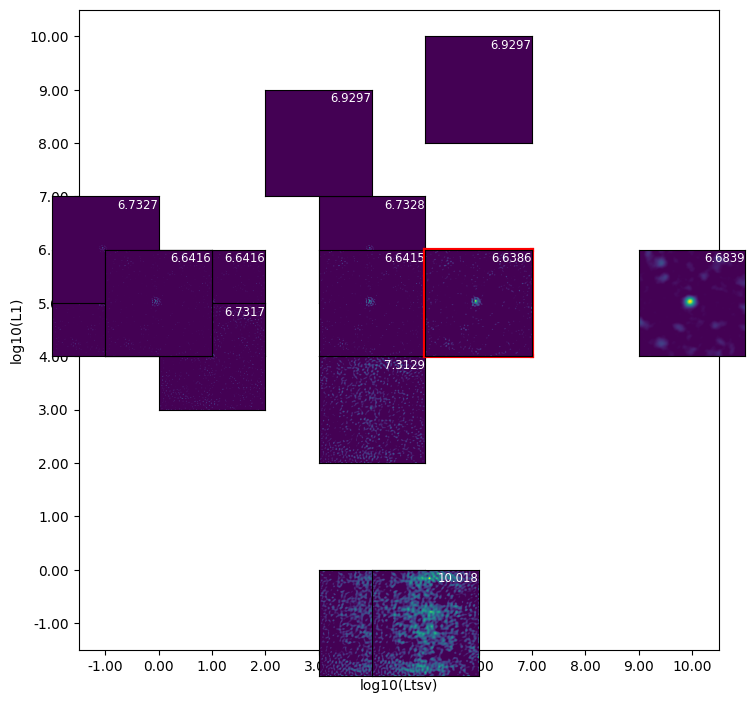

39min 54s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [10]:
%%timeit -n 1 -r 1
%%capture --no-display capture_cv2

L1_list = [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]
Ltsv_list =  [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]
num_fold = 4

worker.crossvalidation(L1_list, Ltsv_list, num_fold=num_fold,
                       imageprefix='twhya_b7cont_cvbayes', imagepolicy='full',
                       summarize=True, figfile='cvresult2.png',
                       datafile='cvresult2.dat', maxiter=1000, resultasinitialimage=False, scalehyperparam=False,
                      optimizer='bayesian', bayesopt_maxiter=15)

## Display Final Image

The created image is displayed here using the <code>matplotlib</code> modular. <br>
By default, if the final image with classical cross-validation exist, that is shown. Here, the area of 100&times;100 pixels around central region of the image is shown. 

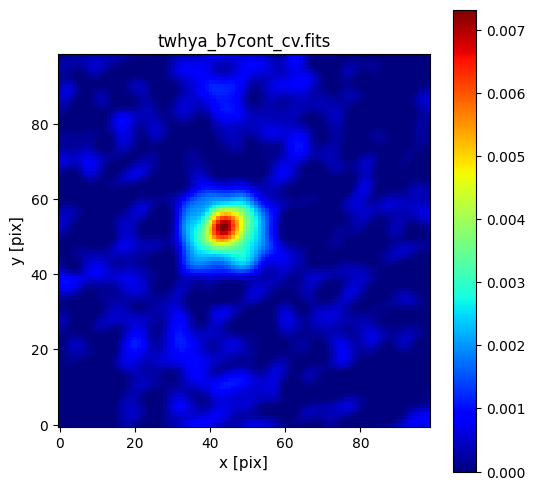

In [14]:
from astropy.io import fits
from matplotlib import pyplot as plt

imname = 'twhya_b7cont_cv.fits'
figname = imname.replace('fits', 'png')

pixs=256; imwd=100; exwd = (pixs-imwd) // 2
_, aa=plt.subplots(1,1, figsize=(6,6))
im=aa.imshow(fits.getdata(imname)[0,0,exwd:((pixs-1)-exwd),exwd:((pixs-1)-exwd)], 
             origin='lower', cmap='jet')
cbar=plt.colorbar(im, ax=aa)
aa.set_title(imname)
aa.set_xlabel("x [pix]",size=11)
aa.set_ylabel("y [pix]",size=11)
plt.savefig(figname, bbox_inches="tight", pad_inches=0.05)
plt.show()